In [ ]:
!pip install keras tensorflow numpy pandas scikit-learn ipykernel imbalanced-learn shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf

# Ensure TensorFlow is using the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU")
else:
    print("No GPU found, using CPU")

# Load and preprocess the data
ics_df = pd.read_csv('Dataset.csv')

ics_df['startDate'] = pd.to_datetime(ics_df['startDate']).view('int64') / 10**9
ics_df['endDate'] = pd.to_datetime(ics_df['endDate']).view('int64') / 10**9

numerical_cols = ics_df.select_dtypes(include=['number']).columns
ics_df[numerical_cols] = ics_df[numerical_cols].fillna(ics_df[numerical_cols].mean())

categorical_cols = ics_df.select_dtypes(include=['object']).columns
ics_df[categorical_cols] = ics_df[categorical_cols].ffill()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    ics_df[col] = le.fit_transform(ics_df[col])
    label_encoders[col] = le

scaler = StandardScaler()
ics_df[numerical_cols] = scaler.fit_transform(ics_df[numerical_cols])

X = ics_df.drop(['IT_M_Label', 'IT_B_Label', 'NST_M_Label', 'NST_B_Label'], axis=1)
y = ics_df['IT_M_Label']

smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)

# Select top features
top_features = ['endDate', 'startOffset', 'end', 'endOffset', 'startDate', 'start',
                'sAckDelayAvg', 'rInterPacketAvg', 'sPayloadSum', 'rBytesSum']
X_res_selected = X_res[top_features].astype(np.float32)
y_res = y_res.astype(np.float32)

# Reshape data for LSTM
n_timesteps = 5
X_seq = []
y_seq = []

for i in range(len(X_res_selected) - n_timesteps):
    X_seq.append(X_res_selected.iloc[i:i+n_timesteps].values)
    y_seq.append(y_res.iloc[i+n_timesteps])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True)

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=2)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

Using GPU


<ipython-input-2-05fdaab2a1bb>:21: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ics_df['startDate'] = pd.to_datetime(ics_df['startDate']).view('int64') / 10**9
<ipython-input-2-05fdaab2a1bb>:22: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ics_df['endDate'] = pd.to_datetime(ics_df['endDate']).view('int64') / 10**9
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1815/1815 - 13s - 7ms/step - accuracy: 0.2628 - loss: -9.1772e+01 - val_accuracy: 0.2589 - val_loss: -1.6724e+02
Epoch 2/10
1815/1815 - 17s - 10ms/step - accuracy: 0.2633 - loss: -2.3992e+02 - val_accuracy: 0.2652 - val_loss: -3.1408e+02
Epoch 3/10
1815/1815 - 10s - 6ms/step - accuracy: 0.2647 - loss: -3.8619e+02 - val_accuracy: 0.2655 - val_loss: -4.6076e+02
Epoch 4/10
1815/1815 - 9s - 5ms/step - accuracy: 0.2644 - loss: -5.3228e+02 - val_accuracy: 0.2649 - val_loss: -6.0738e+02
Epoch 5/10
1815/1815 - 11s - 6ms/step - accuracy: 0.2637 - loss: -6.7849e+02 - val_accuracy: 0.2637 - val_loss: -7.5375e+02
Epoch 6/10
1815/1815 - 9s - 5ms/step - accuracy: 0.2632 - loss: -8.2473e+02 - val_accuracy: 0.2652 - val_loss: -9.0060e+02
Epoch 7/10
1815/1815 - 16s - 9ms/step - accuracy: 0.2626 - loss: -9.7088e+02 - val_accuracy: 0.2642 - val_loss: -1.0470e+03
Epoch 8/10
1815/1815 - 14s - 8ms/step - accuracy: 0.2638 - loss: -1.1169e+03 - val_accuracy: 0.2632 - val_loss: -1.1934e+03
Epoch 9/1

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

conf_matrix_sel = confusion_matrix(y_test, y_pred)
acc_score_sel = accuracy_score(y_test, y_pred)
class_report_sel = classification_report(y_test, y_pred)

# Print Evaluation Metrics
print("Confusion Matrix:\n", conf_matrix_sel)
print("Accuracy Score:", acc_score_sel)
print("Classification Report:\n", class_report_sel)

Confusion Matrix:
 [[3538 2454    0    0    0    0]
 [   0 6139    0    0    0    0]
 [   4 5990    0    0    0    0]
 [  17 6027    0    0    0    0]
 [   8 6057    0    0    0    0]
 [   0 6049    0    0    0    0]]
Accuracy Score: 0.2667089270457239
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.59      0.74      5992
         1.0       0.19      1.00      0.32      6139
         2.0       0.00      0.00      0.00      5994
         3.0       0.00      0.00      0.00      6044
         4.0       0.00      0.00      0.00      6065
         5.0       0.00      0.00      0.00      6049

    accuracy                           0.27     36283
   macro avg       0.20      0.27      0.18     36283
weighted avg       0.20      0.27      0.18     36283



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf

# Ensure TensorFlow is using the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU")
else:
    print("No GPU found, using CPU")

# Load and preprocess the data
ics_df = pd.read_csv('Dataset.csv')

ics_df['startDate'] = pd.to_datetime(ics_df['startDate']).view('int64') / 10**9
ics_df['endDate'] = pd.to_datetime(ics_df['endDate']).view('int64') / 10**9

numerical_cols = ics_df.select_dtypes(include=['number']).columns
ics_df[numerical_cols] = ics_df[numerical_cols].fillna(ics_df[numerical_cols].mean())

categorical_cols = ics_df.select_dtypes(include=['object']).columns
ics_df[categorical_cols] = ics_df[categorical_cols].ffill()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    ics_df[col] = le.fit_transform(ics_df[col])
    label_encoders[col] = le

scaler = StandardScaler()
ics_df[numerical_cols] = scaler.fit_transform(ics_df[numerical_cols])

X = ics_df.drop(['IT_M_Label', 'IT_B_Label', 'NST_M_Label', 'NST_B_Label'], axis=1)
y = ics_df['IT_M_Label']

smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)

# Use the entire dataset
X_res = X_res.astype(np.float32)
y_res = y_res.astype(np.float32)

# Reshape data for LSTM
n_timesteps = 5
X_seq = []
y_seq = []

for i in range(len(X_res) - n_timesteps):
    X_seq.append(X_res.iloc[i:i+n_timesteps].values)
    y_seq.append(y_res.iloc[i+n_timesteps])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True)

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=2)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

Using GPU


<ipython-input-5-62eb9605705c>:21: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ics_df['startDate'] = pd.to_datetime(ics_df['startDate']).view('int64') / 10**9
<ipython-input-5-62eb9605705c>:22: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ics_df['endDate'] = pd.to_datetime(ics_df['endDate']).view('int64') / 10**9
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1815/1815 - 10s - 6ms/step - accuracy: 0.2599 - loss: -9.0283e+01 - val_accuracy: 0.2611 - val_loss: -1.6544e+02
Epoch 2/10
1815/1815 - 9s - 5ms/step - accuracy: 0.2693 - loss: -2.3914e+02 - val_accuracy: 0.2684 - val_loss: -3.1381e+02
Epoch 3/10
1815/1815 - 8s - 4ms/step - accuracy: 0.2716 - loss: -3.8642e+02 - val_accuracy: 0.2736 - val_loss: -4.6186e+02
Epoch 4/10
1815/1815 - 11s - 6ms/step - accuracy: 0.2726 - loss: -5.3380e+02 - val_accuracy: 0.2796 - val_loss: -6.0920e+02
Epoch 5/10
1815/1815 - 8s - 5ms/step - accuracy: 0.2782 - loss: -6.8351e+02 - val_accuracy: 0.2979 - val_loss: -7.6647e+02
Epoch 6/10
1815/1815 - 9s - 5ms/step - accuracy: 0.3070 - loss: -8.4730e+02 - val_accuracy: 0.3177 - val_loss: -9.2764e+02
Epoch 7/10
1815/1815 - 8s - 5ms/step - accuracy: 0.3102 - loss: -1.0008e+03 - val_accuracy: 0.3189 - val_loss: -1.0790e+03
Epoch 8/10
1815/1815 - 8s - 5ms/step - accuracy: 0.3121 - loss: -1.1524e+03 - val_accuracy: 0.3205 - val_loss: -1.2317e+03
Epoch 9/10
181

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.utils import to_categorical
import tensorflow as tf

# Ensure TensorFlow is using the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU")
else:
    print("No GPU found, using CPU")

# Load and preprocess the data
ics_df = pd.read_csv('Dataset.csv')

ics_df['startDate'] = pd.to_datetime(ics_df['startDate']).astype(np.int64) / 10**9
ics_df['endDate'] = pd.to_datetime(ics_df['endDate']).astype(np.int64) / 10**9

numerical_cols = ics_df.select_dtypes(include=['number']).columns
ics_df[numerical_cols] = ics_df[numerical_cols].fillna(ics_df[numerical_cols].mean())

categorical_cols = ics_df.select_dtypes(include=['object']).columns
ics_df[categorical_cols] = ics_df[categorical_cols].ffill()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    ics_df[col] = le.fit_transform(ics_df[col])
    label_encoders[col] = le

scaler = StandardScaler()
ics_df[numerical_cols] = scaler.fit_transform(ics_df[numerical_cols])

X = ics_df.drop(['IT_M_Label', 'IT_B_Label', 'NST_M_Label', 'NST_B_Label'], axis=1)
y = ics_df['IT_M_Label']

smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)

# Use the entire dataset
X_res = X_res.astype(np.float32)
y_res = y_res.astype(np.float32)

# One-hot encode the target variable
y_res = to_categorical(y_res)

# Reshape data for LSTM
n_timesteps = 5
X_seq = []
y_seq = []

for i in range(len(X_res) - n_timesteps):
    X_seq.append(X_res.iloc[i:i+n_timesteps].values)
    y_seq.append(y_res[i+n_timesteps])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True)

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, verbose=2)
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred)}")
print(classification_report(y_test_labels, y_pred))

Using GPU


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
908/908 - 8s - 9ms/step - accuracy: 0.9443 - loss: 0.1864 - val_accuracy: 0.9714 - val_loss: 0.1073
Epoch 2/50
908/908 - 11s - 12ms/step - accuracy: 0.9735 - loss: 0.1039 - val_accuracy: 0.9724 - val_loss: 0.1000
Epoch 3/50
908/908 - 7s - 8ms/step - accuracy: 0.9771 - loss: 0.0911 - val_accuracy: 0.9752 - val_loss: 0.0933
Epoch 4/50
908/908 - 5s - 5ms/step - accuracy: 0.9784 - loss: 0.0862 - val_accuracy: 0.9776 - val_loss: 0.0847
Epoch 5/50
908/908 - 4s - 4ms/step - accuracy: 0.9796 - loss: 0.0809 - val_accuracy: 0.9783 - val_loss: 0.0836
Epoch 6/50
908/908 - 4s - 4ms/step - accuracy: 0.9804 - loss: 0.0784 - val_accuracy: 0.9778 - val_loss: 0.0821
Epoch 7/50
908/908 - 5s - 6ms/step - accuracy: 0.9808 - loss: 0.0750 - val_accuracy: 0.9795 - val_loss: 0.0782
Epoch 8/50
908/908 - 5s - 5ms/step - accuracy: 0.9817 - loss: 0.0729 - val_accuracy: 0.9793 - val_loss: 0.0776
Epoch 9/50
908/908 - 5s - 5ms/step - accuracy: 0.9821 - loss: 0.0700 - val_accuracy: 0.9801 - val_loss: 0.0762

In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.utils import to_categorical
import tensorflow as tf

# Ensure TensorFlow is using the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU")
else:
    print("No GPU found, using CPU")

# Load and preprocess the data
ics_df = pd.read_csv('Dataset.csv')

# Convert dates to timestamp format
ics_df['startDate'] = pd.to_datetime(ics_df['startDate']).astype(np.int64) / 10**9
ics_df['endDate'] = pd.to_datetime(ics_df['endDate']).astype(np.int64) / 10**9

# Fill missing values for numerical columns
numerical_cols = ics_df.select_dtypes(include=['number']).columns
ics_df[numerical_cols] = ics_df[numerical_cols].fillna(ics_df[numerical_cols].mean())

# Fill missing values for categorical columns
categorical_cols = ics_df.select_dtypes(include=['object']).columns
ics_df[categorical_cols] = ics_df[categorical_cols].ffill()

# Label encode the categorical columns (except the target column 'IT_M_Label')
label_encoders = {}
for col in categorical_cols:
        le = LabelEncoder()
        ics_df[col] = le.fit_transform(ics_df[col])
        label_encoders[col] = le

# Standardize the numerical columns
scaler = StandardScaler()
ics_df[numerical_cols] = scaler.fit_transform(ics_df[numerical_cols])

# Separate features and target label
X = ics_df.drop(['IT_M_Label', 'IT_B_Label', 'NST_M_Label', 'NST_B_Label'], axis=1)
y = ics_df['IT_M_Label']

# Apply SMOTE for oversampling
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)

# Use the entire dataset
X_res = X_res.astype(np.float32)

# One-hot encode the target variable
y_res = to_categorical(y_res)

# Reshape data for LSTM with n_timesteps
n_timesteps = 5
X_seq = []
y_seq = []

for i in range(len(X_res) - n_timesteps):
    X_seq.append(X_res.iloc[i:i+n_timesteps].values)
    y_seq.append(y_res[i+n_timesteps])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True)

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, verbose=2)

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

Using GPU


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
908/908 - 10s - 11ms/step - accuracy: 0.9443 - loss: 0.1877 - val_accuracy: 0.9737 - val_loss: 0.1020
Epoch 2/50
908/908 - 5s - 5ms/step - accuracy: 0.9750 - loss: 0.1012 - val_accuracy: 0.9776 - val_loss: 0.0881
Epoch 3/50
908/908 - 5s - 6ms/step - accuracy: 0.9778 - loss: 0.0900 - val_accuracy: 0.9793 - val_loss: 0.0845
Epoch 4/50
908/908 - 5s - 5ms/step - accuracy: 0.9793 - loss: 0.0843 - val_accuracy: 0.9795 - val_loss: 0.0812
Epoch 5/50
908/908 - 6s - 7ms/step - accuracy: 0.9804 - loss: 0.0792 - val_accuracy: 0.9809 - val_loss: 0.0776
Epoch 6/50
908/908 - 4s - 5ms/step - accuracy: 0.9809 - loss: 0.0767 - val_accuracy: 0.9798 - val_loss: 0.0783
Epoch 7/50
908/908 - 6s - 7ms/step - accuracy: 0.9814 - loss: 0.0741 - val_accuracy: 0.9805 - val_loss: 0.0756
Epoch 8/50
908/908 - 6s - 7ms/step - accuracy: 0.9821 - loss: 0.0714 - val_accuracy: 0.9808 - val_loss: 0.0753
Epoch 9/50
908/908 - 5s - 6ms/step - accuracy: 0.9826 - loss: 0.0693 - val_accuracy: 0.9807 - val_loss: 0.0754

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_test_labels = np.argmax(y_test, axis=1)

# Evaluate the model
conf_matrix_sel = confusion_matrix(y_test_labels, y_pred)
acc_score_sel = accuracy_score(y_test_labels, y_pred)
class_report_sel = classification_report(y_test_labels, y_pred)

# Print Evaluation Metrics
print("Confusion Matrix:\n", conf_matrix_sel)
print("Accuracy Score:", acc_score_sel)
print("Classification Report:\n", class_report_sel)

Confusion Matrix:
 [[5962    3   10    6    3    8]
 [  14 6078   38    0    3    6]
 [  85   22 5833    8   20   26]
 [  64    0   16 5941   14    9]
 [  29    7   64   10 5944   11]
 [  34    4   85    9   11 5906]]
Accuracy Score: 0.9829396687153763
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      5992
           1       0.99      0.99      0.99      6139
           2       0.96      0.97      0.97      5994
           3       0.99      0.98      0.99      6044
           4       0.99      0.98      0.99      6065
           5       0.99      0.98      0.98      6049

    accuracy                           0.98     36283
   macro avg       0.98      0.98      0.98     36283
weighted avg       0.98      0.98      0.98     36283



In [8]:
import numpy as np

def permutation_feature_importance(model, X_test, y_test, metric=accuracy_score):
    baseline_score = metric(y_test, np.argmax(model.predict(X_test), axis=1))
    importances = []

    for col in range(X_test.shape[2]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, :, col])
        permuted_score = metric(y_test, np.argmax(model.predict(X_test_permuted), axis=1))
        importances.append(baseline_score - permuted_score)

    return np.array(importances)

# Calculate feature importances
importances = permutation_feature_importance(model, X_test, y_test_labels)
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

1134/1134 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1134/1134 ━

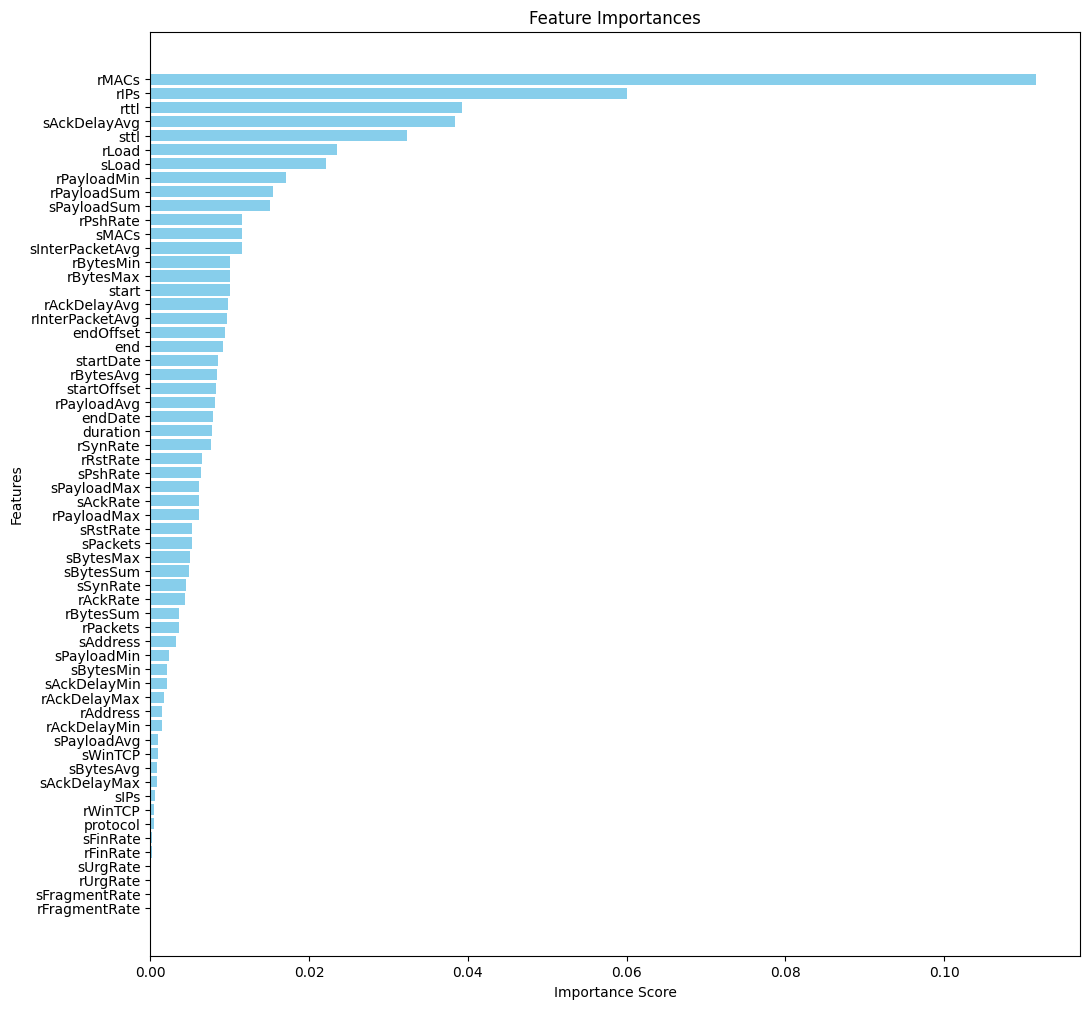

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
N = 10
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.mean(np.abs(shap_values), axis=0)})
top_features = importance_df.sort_values(by='Importance', ascending=False).head(N)['Feature'].values

X_res_selected = X_res[:, :, np.isin(X.columns, top_features)]

X_seq_selected = []
for i in range(len(X_res_selected) - n_timesteps):
    X_seq_selected.append(X_res_selected[i:i+n_timesteps])

X_seq_selected = np.array(X_seq_selected)

X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_seq_selected, y_seq, test_size=0.2, random_state=42, shuffle=True)

# Train LSTM on selected features
model_selected = Sequential()
model_selected.add(Input(shape=(X_train_selected.shape[1], X_train_selected.shape[2])))
model_selected.add(LSTM(100))
model_selected.add(Dropout(0.3))
model_selected.add(Dense(len(np.unique(y_train)), activation='softmax'))

model_selected.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_selected = model_selected.fit(X_train_selected, y_train, epochs=50, batch_size=128, validation_split=0.2, verbose=2)
y_pred_prob_selected = model_selected.predict(X_test_selected)
y_pred_selected = np.argmax(y_pred_prob_selected, axis=1)

# Evaluate the model with selected features
print(f"Accuracy with selected features: {accuracy_score(y_test, y_pred_selected)}")
print(classification_report(y_test, y_pred_selected))